In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

import fsps
import grizli

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


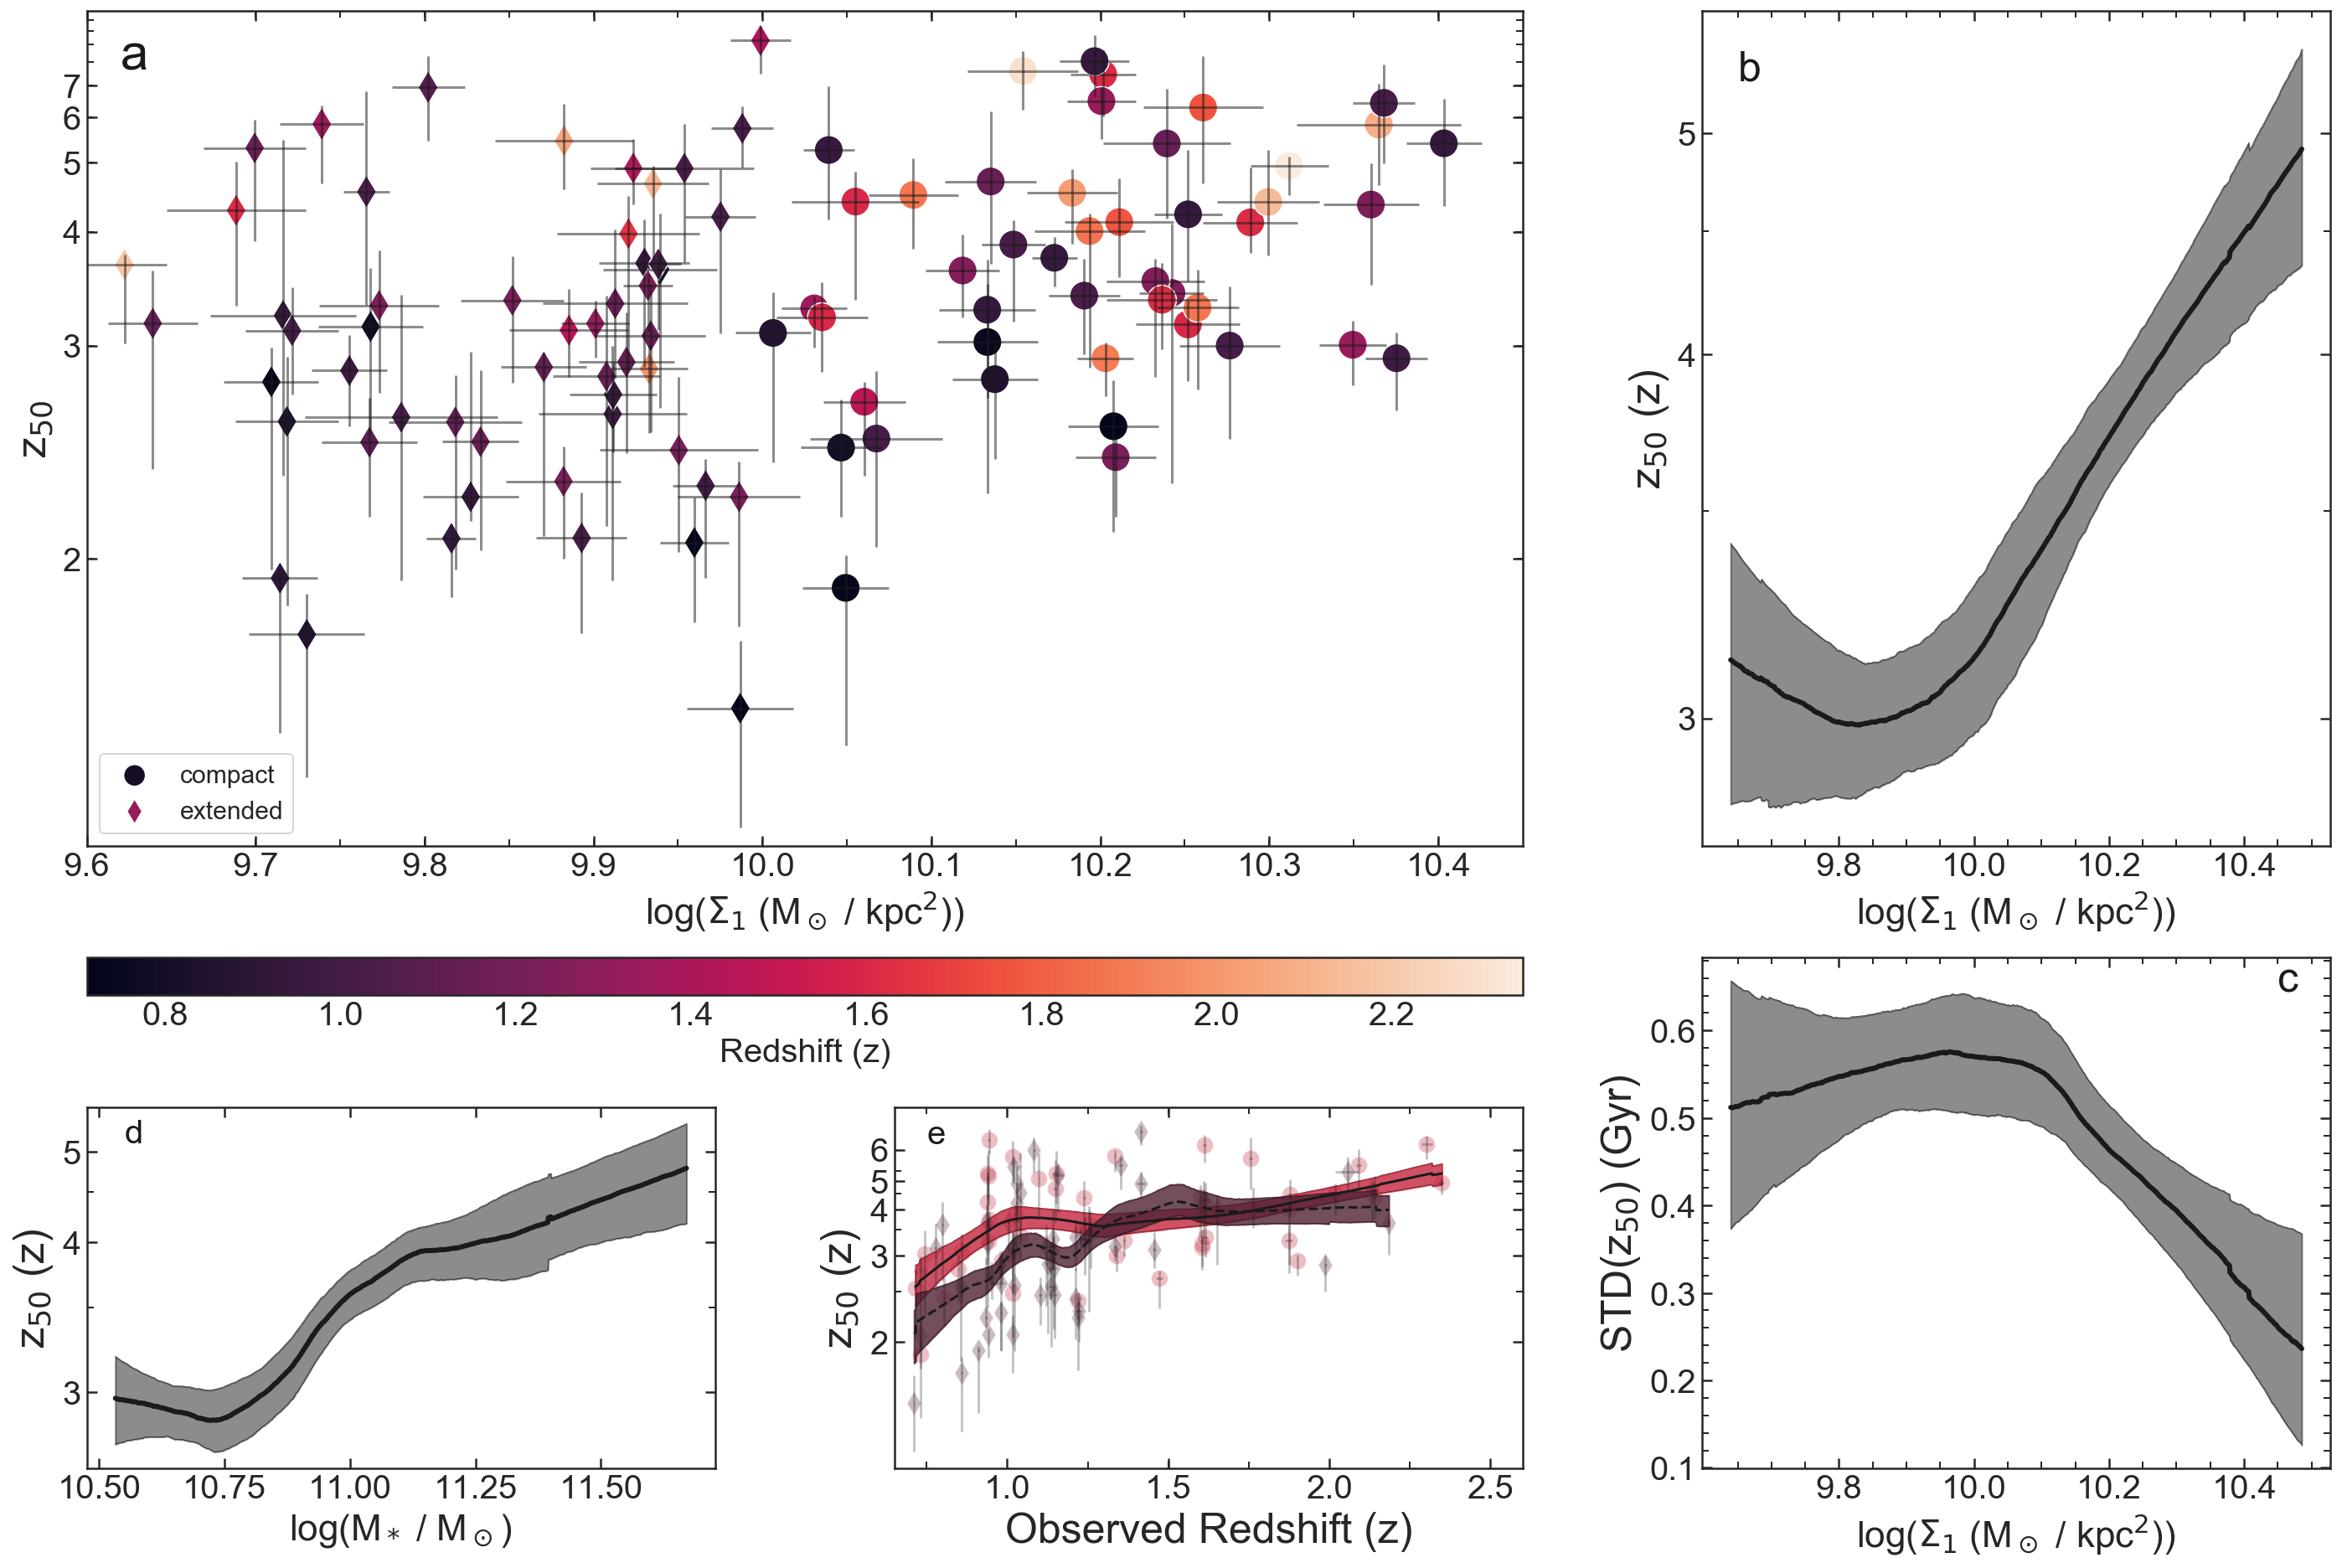

In [17]:
from matplotlib.patches import FancyBboxPatch
from matplotlib import cm
from matplotlib import colors
gs = gridspec.GridSpec(7,6,hspace=1,wspace=0.8, height_ratios=[1,1,1,1,.3,1,1])
# cmap = sea.cubehelix_palette(light=0.9, as_cmap=True, start = 0.1)
cmap = 'rocket'
plt.figure(figsize=[24,16])

ax1 = plt.subplot(gs[0:4,0:4])

sea.scatterplot(np.log10(mdb.query('Sigma1 > 10**10').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 > 10**10').z_50), legend=False, ax=ax1,
            alpha=1, s=300, hue = mdb.query('Sigma1 > 10**10').zgrism, palette = cmap,
                hue_norm = (min(mdb.zgrism),max(mdb.zgrism)), label = 'compact')

sea.scatterplot(np.log10(mdb.query('Sigma1 < 10**10').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 < 10**10').z_50), legend=False, marker='d', ax=ax1,
            alpha=1, s=200, hue = mdb.query('Sigma1 < 10**10').zgrism, palette = cmap,
                hue_norm = (min(mdb.zgrism),max(mdb.zgrism)), label = 'extended')


idx = 0
for i in mdb.index:
    z50lerr = (cosmo.lookback_time(mdb.z_50[i]) - cosmo.lookback_time(mdb.z_50_hdr[i][0])).value
    z50herr = (cosmo.lookback_time(mdb.z_50_hdr[i][1]) - cosmo.lookback_time(mdb.z_50[i])).value

    plt.errorbar(np.log10(mdb.Sigma1[i]), cosmo.lookback_time(mdb.z_50[i]).value, 
                 xerr = mdb.Sigma1_sig[i] / (mdb.Sigma1[i] * np.log(10)), yerr = np.abs([[z50lerr], [z50herr]]), 
                 linestyle = 'none', alpha= 0.5, color = 'k')

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7]).value)
ax1.set_yticklabels([2,3,4,5,6,7])
ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,8,9,10,11]).value, minor=True)
ax1.set_ylim(cosmo.lookback_time(1.3).value,cosmo.lookback_time(12).value)
ax1.set_xticks(np.arange(10.4,9.7,-0.05), minor=True)
plt.xlim(9.6, 10.45)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=22)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=15, loc = 3, markerscale = 0.75)

############ B
ax2 = plt.subplot(gs[0:4,4:])
Sx_range, Sm, Sl, Sh = np.load('../data/plot_points/Sig1_lowess.npy')

plt.plot(Sx_range[20:], Sm[20:], 'k', linewidth = 3)
plt.plot(Sx_range[20:], Sh[20:], 'k', linewidth = 0.2)
plt.plot(Sx_range[20:], Sl[20:], 'k', linewidth = 0.2)
plt.fill_between(Sx_range[20:], Sl[20:], Sh[20:], alpha = 0.5, color = 'k')

plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=22)
ax2.minorticks_on()
ax2.set_yticks(cosmo.lookback_time([3,4,5]).value)
ax2.set_yticklabels([3,4,5])
ax2.set_yticks(cosmo.lookback_time([3.5,4.5]).value, minor=True)
ax2.set_xticks([9.8,10,10.2,10.4])
plt.tick_params(axis='both', which='major', labelsize=20)

############ C

ax5 = plt.subplot(gs[4:,4:])

Sx_range, Sdm, Sdl, Sdh = np.load('../data/plot_points/Sig1_sd_lowess.npy')

plt.plot(Sx_range[20:], Sdm[20:], 'k', linewidth = 3)
plt.plot(Sx_range[20:], Sdh[20:], 'k', linewidth = 0.2)
plt.plot(Sx_range[20:], Sdl[20:], 'k', linewidth = 0.2)
plt.fill_between(Sx_range[20:], Sdl[20:], Sdh[20:], alpha = 0.5, color = 'k')

# plt.xlim(10.45,9.65)
# plt.ylim(0.34,0.75)

plt.ylabel('STD(z$_{50}$) (Gyr)', fontsize=25)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=20)
ax5.minorticks_on()
ax5.set_xticks([9.8,10,10.2,10.4])

############ D

ax3 = plt.subplot(gs[5:,2:4])
Cmdb = mdb.query('Sigma1 > {0}'.format(10**10))
Emdb = mdb.query('Sigma1 < {0}'.format(10**10))
sea.scatterplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),
            color = '#C4253C',ax = ax3, alpha=0.3, s=100)
sea.scatterplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),
            color = '#502234',ax = ax3, alpha=0.3, s=100, marker = 'd')

Cx_range, Cm, Cl, Ch = np.load('../data/plot_points/compact_lowess.npy')
Ex_range, Em, El, Eh = np.load('../data/plot_points/extend_lowess.npy')

plt.plot(Cx_range, Cm, 'k')
plt.plot(Cx_range, Ch, 'k', linewidth = 0.2)
plt.plot(Cx_range, Cl, 'k', linewidth = 0.2)
plt.fill_between(Cx_range, Cl, Ch, alpha = 0.8, color = '#C4253C')

plt.plot(Ex_range, Em, 'k--')
plt.plot(Ex_range, Eh, 'k', linewidth = 0.2)
plt.plot(Ex_range, El, 'k', linewidth = 0.2)
plt.fill_between(Ex_range, El, Eh, alpha = 0.8, color = '#502234')



idx = 0
for i in mdb.index:
    z50lerr = (cosmo.lookback_time(mdb.z_50[i]) - cosmo.lookback_time(mdb.z_50_hdr[i][0])).value
    z50herr = (cosmo.lookback_time(mdb.z_50_hdr[i][1]) - cosmo.lookback_time(mdb.z_50[i])).value

    zlerr = (mdb.zgrism[i] - mdb.zgrism_hdr[i][0])
    zherr = (mdb.zgrism_hdr[i][1] - mdb.zgrism[i])
    
    plt.errorbar(mdb.zgrism[i], cosmo.lookback_time(mdb.z_50[i]).value, 
                 xerr = np.abs([[zlerr], [zherr]]), yerr = np.abs([[z50lerr], [z50herr]]), 
                 linestyle = 'none', alpha= 0.25, color = 'k')

ax3.set_xlabel('Observed Redshift (z)', fontsize=25)
ax3.set_ylabel('z$_{50}$ (z)', fontsize=25)

ax3.set_yticks(cosmo.lookback_time([2,3,4,5,7]).value)
ax3.set_yticklabels([2,3,4,5,6,7,9])
ax3.set_xticks([0.75, 1.25, 1.5,1.75, 2.25], minor = True)
ax3.set_xlim(0.65,2.6)
ax3.set_yticks(cosmo.lookback_time([2.5,3.5,4.5,5.5]).value, minor=True)
plt.tick_params(axis='both', which='major', labelsize=20)

############ E
ax4 = plt.subplot(gs[5:,:2])
Mx_range, Mdm, Mdl, Mdh = np.load('../data/plot_points/mass_lowess.npy')

plt.plot(Mx_range[27:], Mdm[27:], 'k', linewidth = 3)
plt.plot(Mx_range[27:], Mdh[27:], 'k', linewidth = 0.2)
plt.plot(Mx_range[27:], Mdl[27:], 'k', linewidth = 0.2)
plt.fill_between(Mx_range[27:], Mdl[27:], Mdh[27:], alpha = 0.5, color = 'k')

plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.xlabel('log(M$_*$ / M$_\odot$)', fontsize=22)
ax4.set_yticks(cosmo.lookback_time([3,4,5]).value)
ax4.set_yticklabels([3,4,5])
ax4.set_yticks(cosmo.lookback_time([3.5,4.5]).value, minor=True)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1.text(9.62, 12.8,'a', fontsize = 30, color = 'k')
ax2.text(9.65, 12.4,'b', fontsize = 25, color = 'k')
ax5.text(10.45, 0.645,'c', fontsize = 25, color = 'k')
ax3.text(0.75, 12.8,'e', fontsize = 20, color = 'k')
ax4.text(10.55, 12.35,'d', fontsize = 20, color = 'k',)

ax6 = plt.subplot(gs[4,0:4])
norm = mpl.colors.Normalize(vmin=min(mdb.zgrism), vmax = max(mdb.zgrism))
mpl.colorbar.ColorbarBase(ax6, cmap = cmap, norm=norm, orientation='horizontal')
ax6.set_xlabel('Redshift (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# ax6.yaxis.set_label_position('')

plt.savefig('../plots/compact_sig1_v2.png', bbox_inches = 'tight')

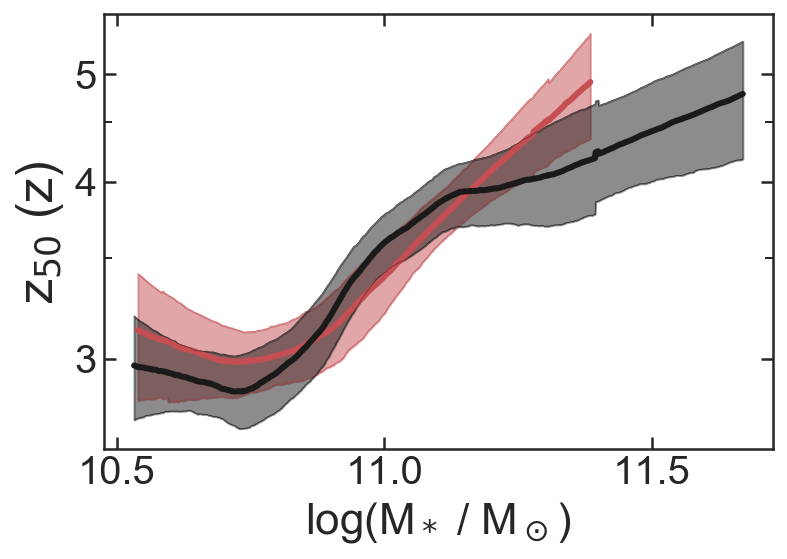

In [26]:
############ B
ax = plt.subplot()
Sx_range, Sm, Sl, Sh = np.load('../data/plot_points/Sig1_lowess.npy')

plt.plot(Sx_range[20:]+0.9, Sm[20:], 'r', linewidth = 3)
plt.plot(Sx_range[20:]+0.9, Sh[20:], 'r', linewidth = 0.2)
plt.plot(Sx_range[20:]+0.9, Sl[20:], 'r', linewidth = 0.2)
plt.fill_between(Sx_range[20:]+0.9, Sl[20:], Sh[20:], alpha = 0.5, color = 'r')


############ E
Mx_range, Mdm, Mdl, Mdh = np.load('../data/plot_points/mass_lowess.npy')

plt.plot(Mx_range[27:], Mdm[27:], 'k', linewidth = 3)
plt.plot(Mx_range[27:], Mdh[27:], 'k', linewidth = 0.2)
plt.plot(Mx_range[27:], Mdl[27:], 'k', linewidth = 0.2)
plt.fill_between(Mx_range[27:], Mdl[27:], Mdh[27:], alpha = 0.5, color = 'k')

plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.xlabel('log(M$_*$ / M$_\odot$)', fontsize=22)
ax.set_yticks(cosmo.lookback_time([3,4,5]).value)
ax.set_yticklabels([3,4,5])
ax.set_yticks(cosmo.lookback_time([3.5,4.5]).value, minor=True)
plt.tick_params(axis='both', which='major', labelsize=20)


In [3]:
f105N = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')
f105N_img = f105N[0].data

f105S = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')
f105S_img = f105S[0].data

In [4]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

In [5]:
wfN = wcs.WCS(f105N[0].header)
wfS = wcs.WCS(f105S[0].header)

In [6]:
def RS_img(img):
    IMG = np.array(img) + 100

    m = np.percentile(IMG, 5)
    M = np.percentile(IMG, 99)

    IMG -= m
    IMG[IMG <= 0] = 0
    IMG /= (M-m)
    IMG[IMG > 1] =1
    return np.arcsinh(IMG)

def get_positions(ra, dec, D, W):
    [Of, Lf, Hf]=W.wcs_world2pix([[ra ,dec],[ra-D ,dec-D], [ra+D ,dec+D]],1)
    Of = Of.astype(int)
    Lf = Lf.astype(int)
    Hf = Hf.astype(int)
    return Of, Lf, Hf

In [7]:
def img_ext(field, gid):
    D = (1.5 * u.arcsec * (1*u.arcmin/(60*u.arcsec)) * (1*u.deg/(60*u.arcmin))).value

    if field == 'GND':
        ra=v4N.query('id == {}'.format(gid)).ra.values[0]
        dec=v4N.query('id == {}'.format(gid)).dec.values[0]
        W = wfN
    if field == 'GSD':
        ra=v4S.query('id == {}'.format(gid)).ra.values[0]
        dec=v4S.query('id == {}'.format(gid)).dec.values[0]
        W = wfS

    Of1, Lf1, Hf1 = get_positions(ra, dec, D, W)

    dx = np.abs(Of1[0] - Lf1[0])

    if field == 'GND':
        gal_img = f105N_img[Of1[1] - dx : Of1[1]+1 + dx , Of1[0] - dx: Of1[0]+1 + dx]
    if field == 'GSD':
        gal_img = f105S_img[Of1[1] - dx : Of1[1]+1 + dx , Of1[0] - dx: Of1[0]+1 + dx]
    return gal_img

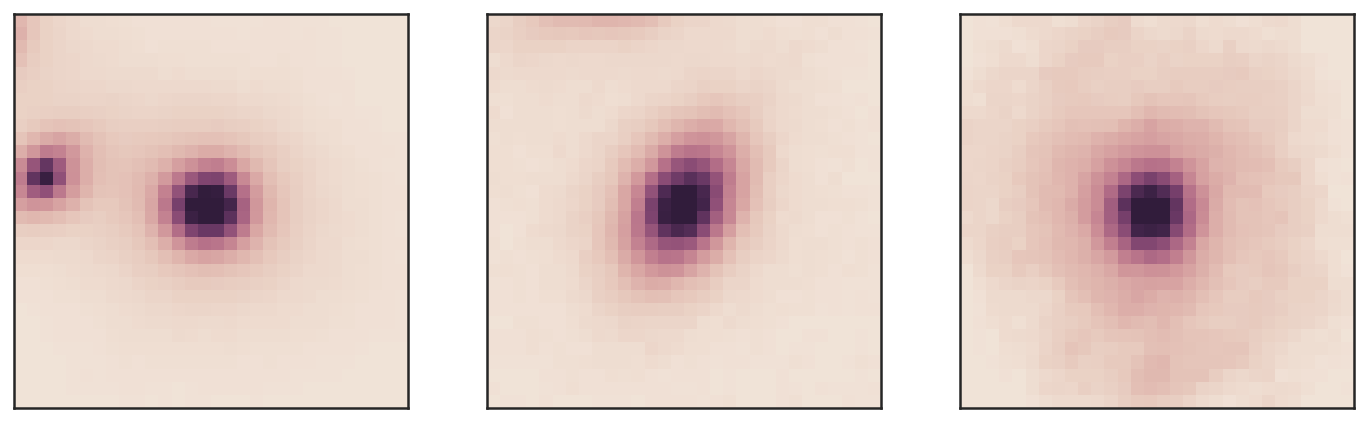

In [9]:
gids = [39170, 40862, 45775 ]

gs = gridspec.GridSpec(1,3)
plt.figure(figsize = [12,6])
cmap = sea.cubehelix_palette(light=0.9, as_cmap=True, start = 0.1)

for i in range(len(gids)):
    IMG = RS_img(img_ext('GSD', gids[i]))

    iIMG = interp2d(np.arange(45),np.arange(45),IMG)(np.linspace(0,44, 30), np.linspace(0,44, 30))

    plt.subplot(gs[i])
    plt.imshow(iIMG, cmap =cmap)
    plt.xticks([])
    plt.yticks([])

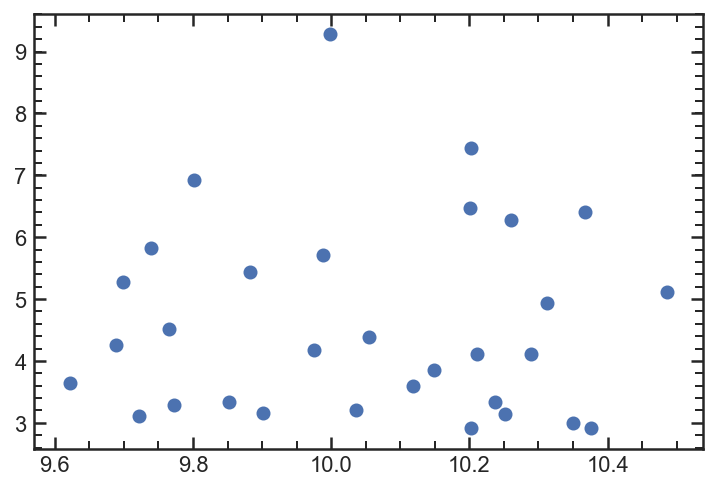

In [9]:
plt.scatter(np.log10(mdb.query('field == "GSD" and z_50 > 2.9').Sigma1), mdb.query('field == "GSD" and z_50 > 2.9').z_50)

In [10]:
mdb.query('field == "GSD" and z_50 > 2.9 and 10**9.6 < Sigma1 < 10**9.8').id

55     44133
108    39805
143    38843
159    45972
193    38785
194    42221
273    45775
Name: id, dtype: int64

In [16]:
mdb.query('z_50 > 2.9 and 0.9 < zgrism < 1.1 and field == "GSD"').id

25     39631
44     29928
112    43615
157    39170
159    45972
172    44620
194    42221
213    39241
274    19148
Name: id, dtype: int64

39241


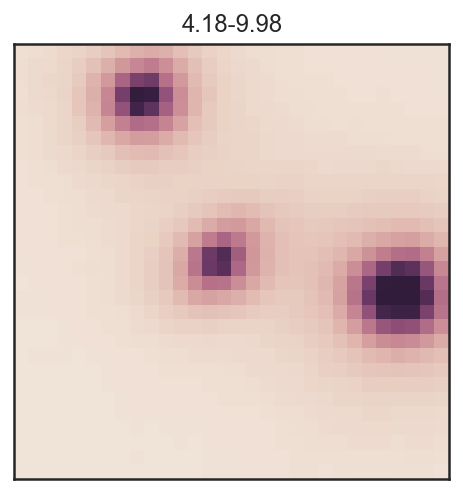

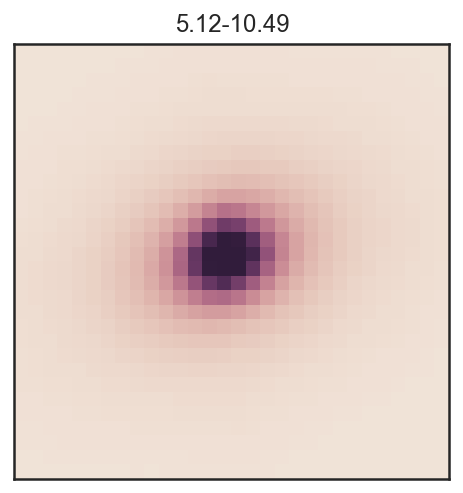

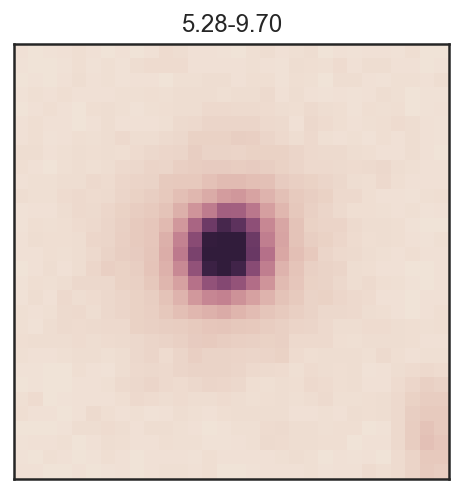

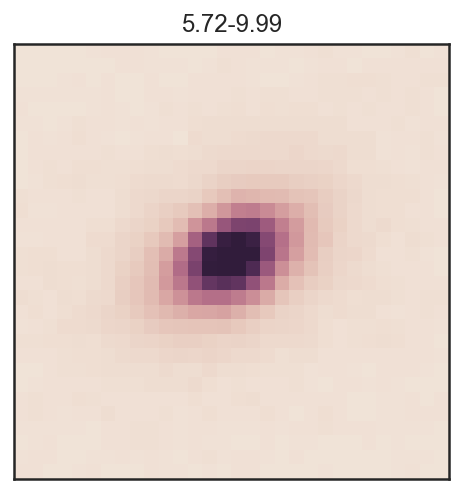

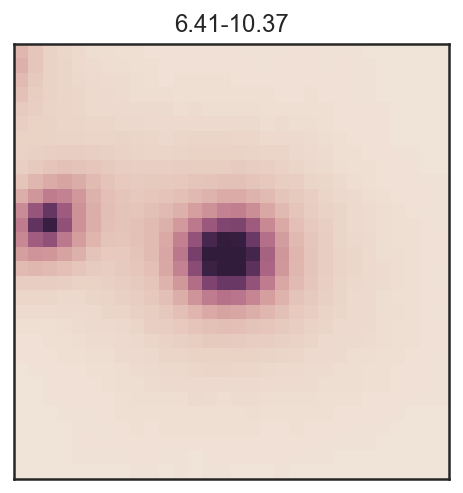

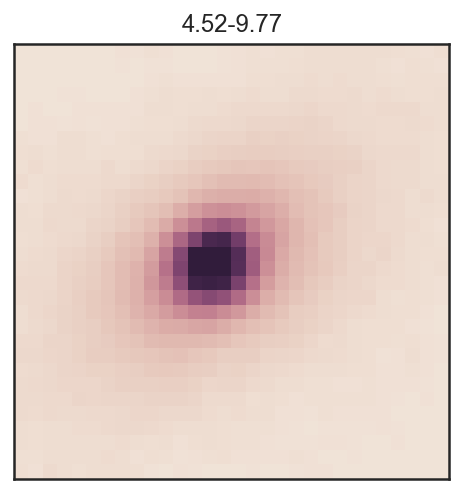

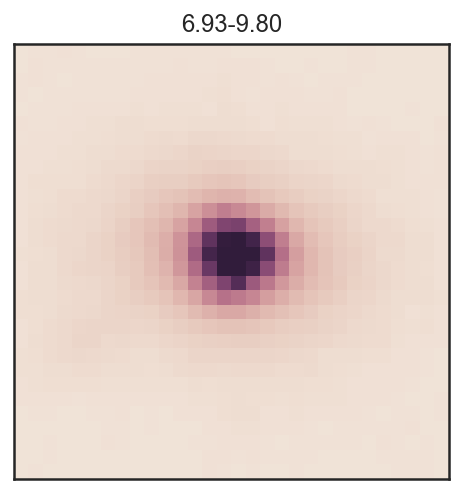

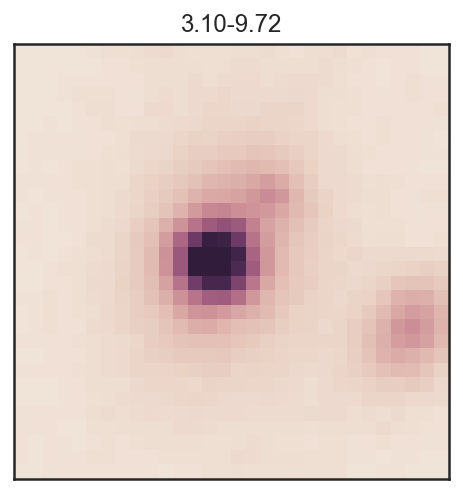

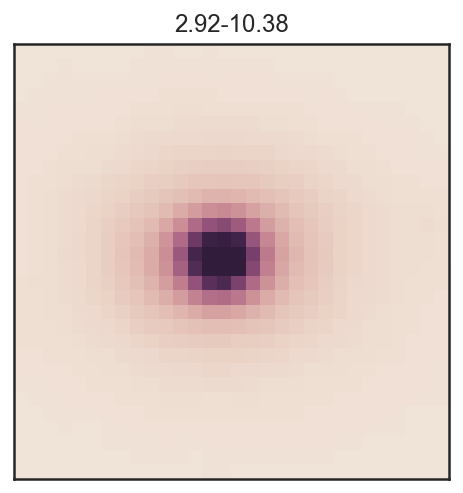

In [10]:
for i in mdb.query('z_50 > 2.9 and 0.9 < zgrism < 1.2 and field == "GSD"').index:
    try:
        IMG = RS_img(img_ext('GSD', mdb.id[i]))
        iIMG = interp2d(np.arange(45),np.arange(45),IMG)(np.linspace(0,44, 30), np.linspace(0,44, 30))
        plt.figure()
        plt.imshow(iIMG, cmap =cmap)
        plt.xticks([])
        plt.yticks([])
        plt.title('{:1.2f}-{:1.2f}'.format(mdb.z_50[i], np.log10(mdb.Sigma1[i])))
        plt.savefig('../plots/CEERS/GSD-{}.png'.format(mdb.id[i]), bbox_inches = 'tight')
    except:
        print(mdb.id[i])

In [103]:
mdb.query('id == 39170').Re,mdb.query('id == 39170').n,mdb.query('id == 39170').lmass,

(157    3.203853
 Name: Re, dtype: float64, 157    5.7016
 Name: n, dtype: float64, 157    11.396621
 Name: lmass, dtype: float64)

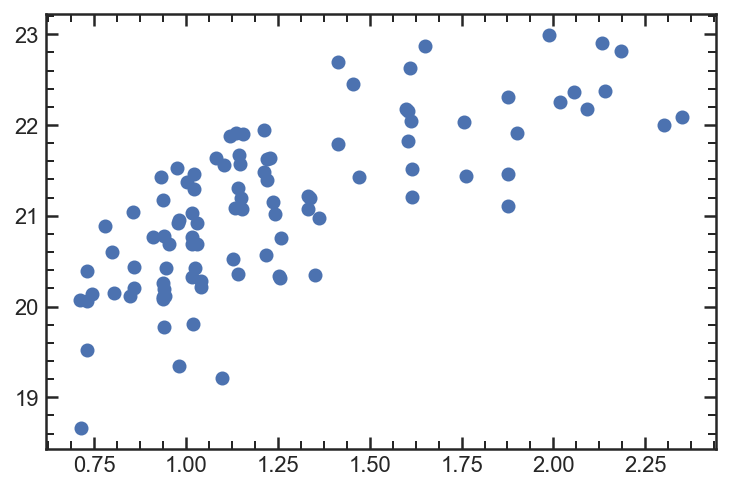

In [96]:
plt.scatter(mdb.zgrism,mdb.mag_f160)

In [94]:
mdb.n[59],mdb.Ra[59],mdb.mag_f160[59]

(4.0455, 0.682434, 20.52)

In [60]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 5, dust_type = 1)

In [66]:
sp.params['tau'] = 3
wave2,flux2 = sp.get_spectrum(tage=4, peraa=True)

sp.params['tau'] = 0.3
wave1,flux1 = sp.get_spectrum(tage=4, peraa=True)

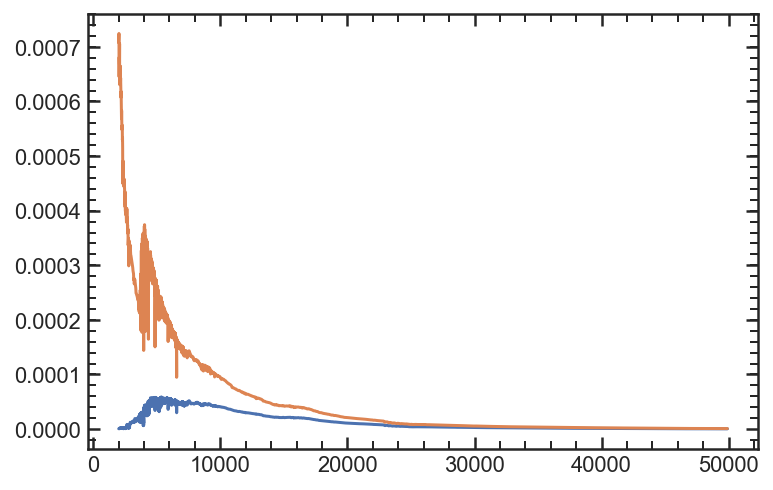

In [75]:
IDX = [U for U in range(len(wave1)) if 2000 < wave1[U] < 50000]


plt.plot(wave1[IDX],flux1[IDX])
plt.plot(wave2[IDX],flux2[IDX])

# plt.xlim(3000,8000)

In [78]:
np.savetxt('../data/tau_03.txt',[wave1[IDX], flux1[IDX]])
np.savetxt('../data/tau_3.txt',[wave2[IDX], flux2[IDX]])

In [85]:
t03 = pd.DataFrame({'wave' : wave1[IDX]/1E4, 'flux' : flux1[IDX] })
t3 = pd.DataFrame({'wave' : wave2[IDX]/1E4, 'flux' : flux2[IDX] })

In [86]:
t03 = t03[['wave', 'flux']]
t3 = t3[['wave', 'flux']]

In [87]:
t03.to_csv('../data/tau_03.txt', sep = ' ', index=False)
t3.to_csv('../data/tau_3.txt', sep = ' ', index=False)

In [138]:
def IR_prime(n, Reff, R):
    b = 2*n - (1/3)  
    return R * np.exp(-b * (R / Reff)**(1/n))

def Sigma_1_simp(Reff, n, mass):    
    
    r_range = np.linspace(0,1,1000)
    top = np.trapz(IR_prime(n, Reff, r_range), r_range)
    
    r_range = np.linspace(0,100,100000)
    bottom = np.trapz(IR_prime(n, Reff, r_range), r_range)   
    
    return (top / bottom) * 10**mass/ np.pi

def Sigma_1_two(Reff1, Reff2, n1, n2, perc, mass):    
    
    r_range = np.linspace(0,1,1000)
    top = np.trapz(IR_prime(n1, Reff1, r_range) + IR_prime(n2, Reff2, r_range)*perc, r_range)
    
    r_range = np.linspace(0,100,100000)
    bottom = np.trapz(IR_prime(n1, Reff1, r_range) + IR_prime(n2, Reff2, r_range)*perc, r_range)   
    
    return (top / bottom) * 10**mass/ np.pi

In [149]:
np.log10(Sigma_1_simp(3.2, 5.7, 11.34)), np.log10(Sigma_1_two(3.2, 1.5, 5.7, 1, 0.1, 10.6))

(10.254877360820668, 9.586650210702757)

In [150]:
np.log10(Sigma_1_simp(1.5, 1, 10.6)),np.log10(Sigma_1_simp(3.2, 1, 11.34)),

(9.58720257755112, 9.827766455601873)

In [134]:
r_range = np.linspace(0,100,100000)
prof1 = IR_prime(3.2, 4, r_range)
prof2 = IR_prime(1.5895, 1., r_range)

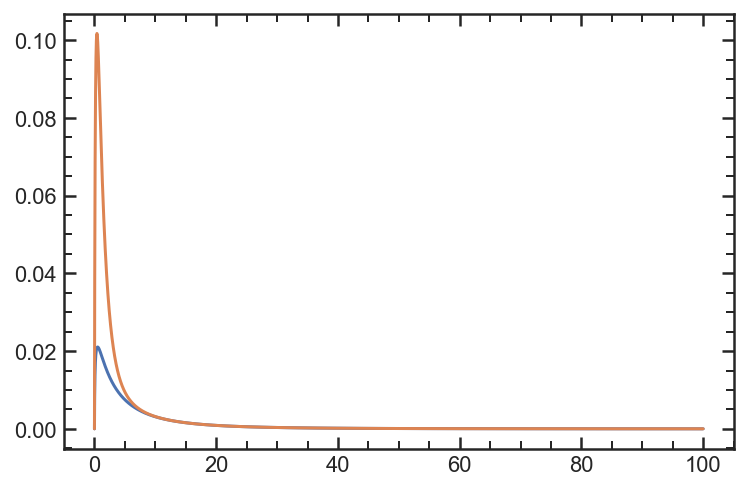

In [136]:
plt.plot(r_range, prof1)
plt.plot(r_range,  prof1+prof2)

In [63]:
mdb.n[207],mdb.Ra[207], mdb.mag_f160[207], mdb.lmass[207],mdb.Re[207],mdb.zgrism[207], mdb.id[207]

(5.1229,
 0.211134,
 21.8787,
 10.5303600237309,
 1.6150582535648406,
 1.1208036286128034,
 23857)

In [26]:
mdb.n[157],mdb.Ra[157],mdb.mag_f160[157], mdb.lmass[157],mdb.Re[157],mdb.zgrism[157]

(5.7016,
 0.42225,
 19.81,
 11.396621079013798,
 3.2038533601399295,
 1.018142320964341)

In [166]:
np.log10(Sigma_1_simp(1.615, 4, 10.53)), np.log10(Sigma_1_simp(3.2, 4, 11.397))

(9.603088201530197, 10.243511416528364)

In [35]:
ls ../data/CEERS/wb34043_c1_2020-02-19_17.40.43/image/

image_detector.fits     image_saturation.fits
image_ngroups_map.fits  image_snr.fits


In [64]:
dat = fits.open('../data/CEERS/wb34074_c1_2020-02-19_19.45.31/image/image_snr.fits')

In [65]:
img = dat[0].data

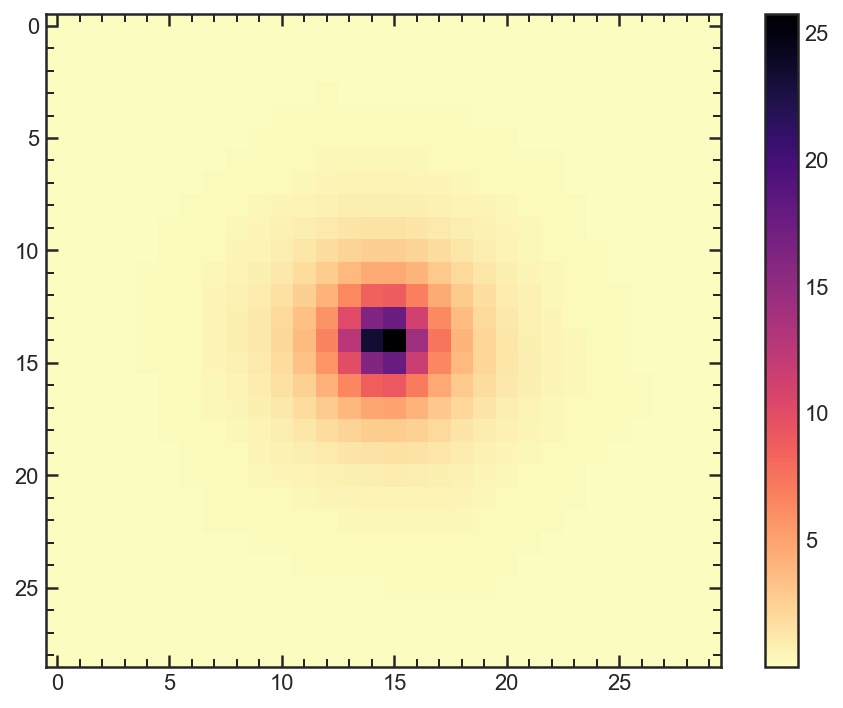

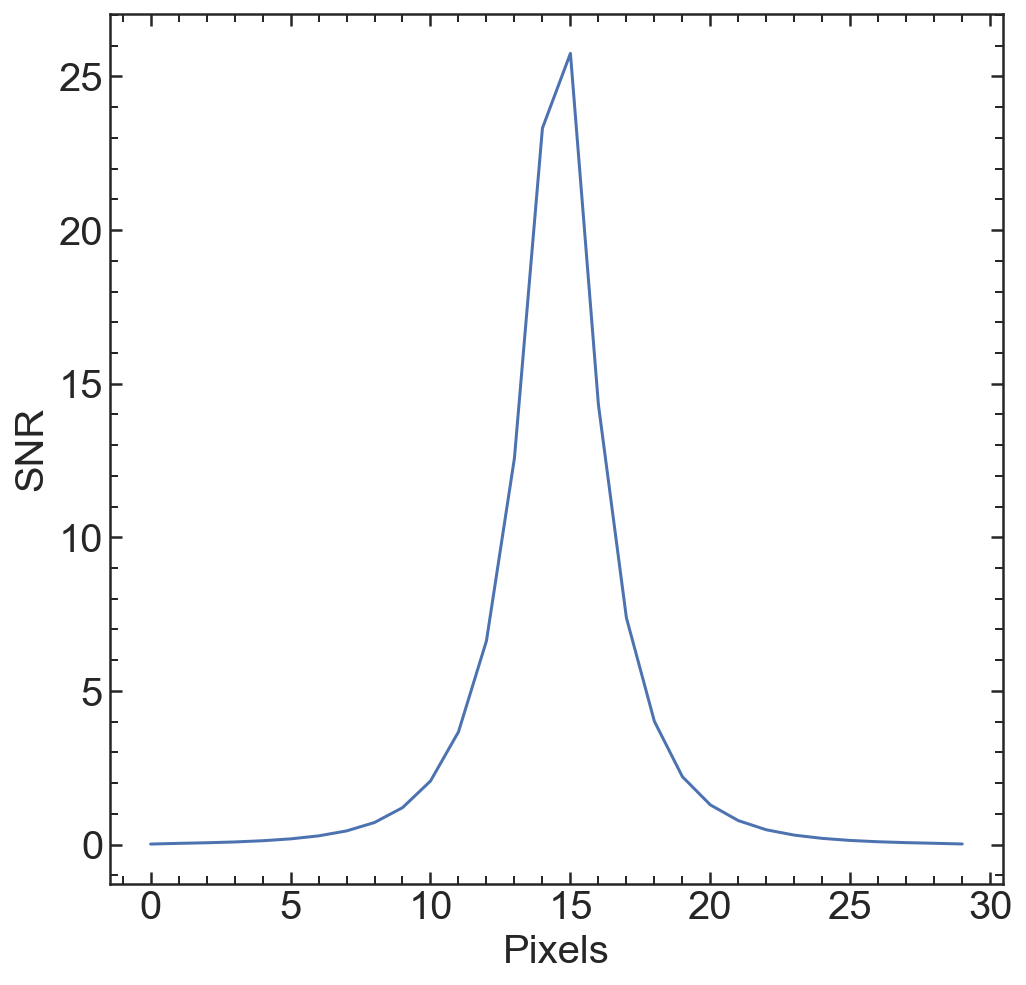

In [66]:
plt.figure(figsize=[8,6])

plt.imshow(img, cmap = 'magma_r')
plt.colorbar()
plt.savefig('../plots/CEERS/GSD-23857_snr_all.png', bbox_inches = 'tight')


plt.figure(figsize=[8,8])
plt.plot(img[14])
plt.xlabel('Pixels', fontsize = 20)
plt.ylabel('SNR', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/CEERS/GSD-23857_snr_slice.png', bbox_inches = 'tight')


In [29]:
{
    "background": "medium",
    "calculation": {
        "effects": {
            "background": true,
            "ipc": true,
            "saturation": true
        },
        "noise": {
            "crs": true,
            "darkcurrent": true,
            "ffnoise": true,
            "readnoise": true,
            "rn_correlation": true
        }
    },
    "configuration": {
        "detector": {
            "nexp": 1,
            "ngroup": 8,
            "nint": 10,
            "readmode": "nrs",
            "subarray": "full"
        },
        "dynamic_scene": true,
        "instrument": {
            "aperture": "imager",
            "disperser": null,
            "filter": "f560w",
            "instrument": "nirspec",
            "mode": "IFU"
        },
        "max_scene_size": 40.0,
        "scene_size": 6.0
    },
    "scene": [
        {
            "id": 1,
            "position": {
                "orientation": 0.0,
                "x_offset": 0.0,
                "y_offset": 0.0
            },
            "shape": {
                "geometry": "point"
            },
            "spectrum": {
                "extinction": {
                    "bandpass": "v",
                    "law": "mw_rv_31",
                    "unit": "mag",
                    "value": 0.0
                },
                "lines": [],
                "name": "generic source",
                "normalization": {
                    "norm_flux": 0.1,
                    "norm_fluxunit": "mjy",
                    "norm_wave": 2.0,
                    "norm_waveunit": "microns",
                    "type": "at_lambda"
                },
                "redshift": 0.0,
                "sed": {
                    "sed_type": "flat",
                    "unit": "fnu"
                }
            }
        }
    ],
    "strategy": {
        "aperture_size": 0.24,
        "background_subtraction": true,
        "display_string": "Imaging Aperture Photometry",
        "method": "imagingapphot",
        "sky_annulus": [
            0.72,
            0.96
        ],
        "target_source": 1,
        "target_type": "",
        "target_xy": [
            0.0,
            0.0
        ],
        "units": "arcsec"
    }
}


4.875076173065204

In [33]:
from pandeia.engine.perform_calculation import perform_calculation
import json

# Load in your scene file
with open("../configurations/jwst/miri/imaging.json") as f:
    imgr_data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../configurations/jwst/miri/imaging.json'

array([[4.14920000e+00, 4.14819500e+00, 4.14719000e+00, ...,
        3.00249500e+00, 3.00149000e+00, 3.00048500e+00],
       [4.48259002e-06, 1.02652762e-05, 1.38288400e-05, ...,
        4.53475411e-06, 4.18912465e-06, 3.81893543e-06],
       [3.78898420e-02, 3.78899239e-02, 3.78899752e-02, ...,
        3.78898393e-02, 3.78898343e-02, 3.78898289e-02]])